In [30]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# Step 1: Load the Data
file_path = r'data0_200\train_data_0_20.csv'
data = pd.read_csv(file_path)

# Convert date column to datetime format for plotting purposes
data['date'] = pd.to_datetime(data['date'])

# Select the chosen features, including the tic and date columns for organization
selected_features = ['tic', 'date', 'close', 'volume', 'day', 'macd', 'boll_ub', 
                     'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 
                     'close_60_sma', 'vix', 'turbulence']
data = data[selected_features]
data

C:\Users\Haoran Yang\AppData\Local\Temp\ipykernel_32084\368316405.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,tic,date,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,ARL,2015-10-01,7.030000,1300,3,0.143887,7.711643,6.701357,56.887952,-9.827596,18.536363,7.094667,6.268500,22.549999,0.00000
1,BH,2015-10-01,241.353332,8850,3,-4.967863,254.549970,240.808029,40.288793,-150.888171,28.459297,249.845555,267.082889,22.549999,0.00000
2,CIX,2015-10-01,7.353430,200,3,-0.012619,7.685737,7.304256,45.040564,-93.320721,20.168078,7.473885,7.577119,22.549999,0.00000
3,FDBC,2015-10-01,18.255781,0,3,0.222549,18.046982,16.483571,73.236650,320.645967,36.525050,17.178692,17.132404,22.549999,0.00000
4,GEF,2015-10-01,22.461304,293500,3,0.044349,25.739347,22.292050,45.435755,-15.270326,5.304819,22.890805,22.948372,22.549999,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38347,STRS,2024-09-18,26.280001,13800,2,0.378013,28.013316,23.029684,51.882147,130.492371,15.690076,25.004000,25.837167,18.230000,13.37937
38348,SWKH,2024-09-18,16.950001,20000,2,-0.057518,17.668155,16.717845,48.225863,-46.888029,9.608028,17.130333,17.090667,18.230000,13.37937
38349,TCI,2024-09-18,27.620001,3000,2,-0.396883,30.630781,27.208219,43.494571,-101.713401,18.301329,29.073333,29.319500,18.230000,13.37937
38350,VABK,2024-09-18,41.040001,13800,2,1.288482,42.184776,36.185983,62.731284,104.565840,28.385168,37.864954,36.354800,18.230000,13.37937


In [49]:
# Preprocess by normalizing each feature independently
scalers = {}
for column in selected_features[2:]:  # Skip 'tic' and 'date' columns
    scaler = StandardScaler()
    data[column] = scaler.fit_transform(data[[column]])
    scalers[column] = scaler

# Step 3: Group by ticker and prepare sequences for model training
sequence_length = 120
sequences = []
targets = []
dates = []
tickers = []

for ticker in data['tic'].unique():
    ticker_data = data[data['tic'] == ticker]
    
    # Generate sequences and targets for each ticker
    for i in range(len(ticker_data) - sequence_length):
        # Append features for the sequence
        sequences.append(ticker_data.iloc[i:i+sequence_length][selected_features[2:]].values)
        
        # Append only the closing price as the target (single value)
        targets.append(ticker_data.iloc[i+sequence_length]['close'])  # Target is next day's close price
        
        # Keep track of dates and tickers for analysis
        dates.append(ticker_data.iloc[i+sequence_length]['date'])
        tickers.append(ticker)

# Convert to numpy arrays
X = np.array(sequences)
y = np.array(targets).reshape(-1, 1)  # Ensuring y is of shape (samples, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device).squeeze()  # Ensure y has shape (samples,)

# Create DataLoader
batch_size = 32
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [50]:
# Define Encoder-Decoder model with updated input dimension
class Encoder(nn.Module):
    def __init__(self, input_dim=X.shape[2], hidden_dim=200, latent_dim=80):
        super(Encoder, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, 200, batch_first=True)
        self.lstm2 = nn.LSTM(200, 100, batch_first=True)
        self.lstm3 = nn.LSTM(100, latent_dim, batch_first=True)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, (h, c) = self.lstm3(x)
        return h, c

class Decoder(nn.Module):
    def __init__(self, latent_dim=80, hidden_dim=200, output_dim=1):
        super(Decoder, self).__init__()
        self.lstm1 = nn.LSTM(latent_dim, 80, batch_first=True)
        self.lstm2 = nn.LSTM(80, 100, batch_first=True)
        self.lstm3 = nn.LSTM(100, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, encoder_hidden):
        x, _ = self.lstm1(x, encoder_hidden)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])
        return x

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoder_hidden = self.encoder(x)
        decoder_input = torch.zeros(x.size(0), 1, 80).to(device)
        output = self.decoder(decoder_input, encoder_hidden)
        return output.squeeze(-1)

In [51]:
# Instantiate and train the model
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Seq2Seq(encoder, decoder).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
# Step 4: Train the Model
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)  # Output shape should be (batch_size, 1)
        loss = criterion(output, y_batch)  # y_batch shape should be (batch_size,)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.0440
Epoch [2/10], Loss: 0.0040
Epoch [3/10], Loss: 0.0036
Epoch [4/10], Loss: 0.0033


KeyboardInterrupt: 

<Figure size 1400x800 with 0 Axes>

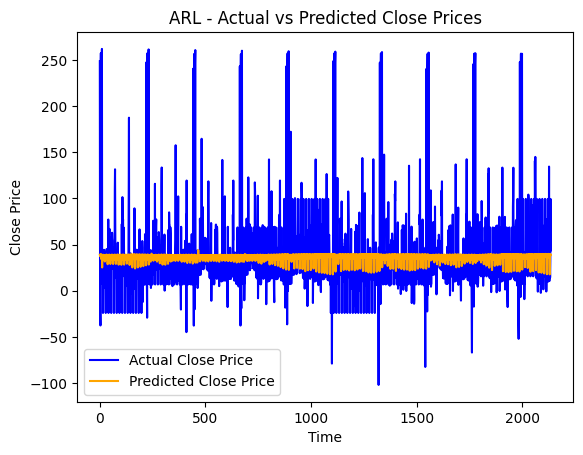

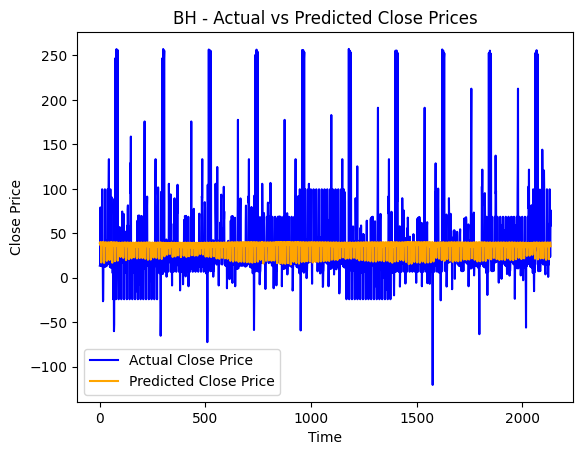

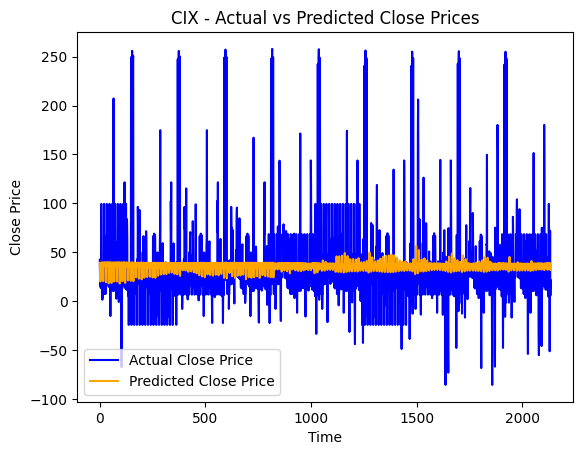

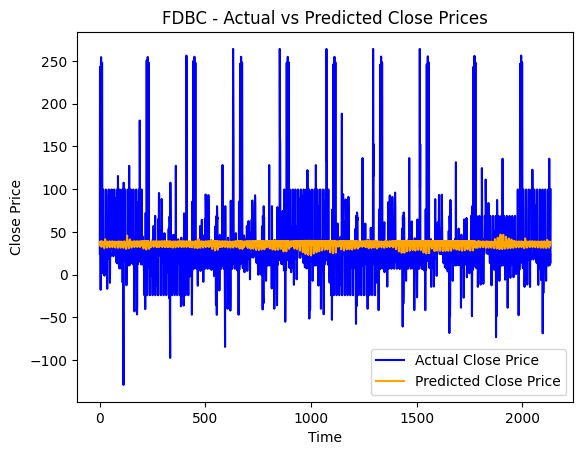

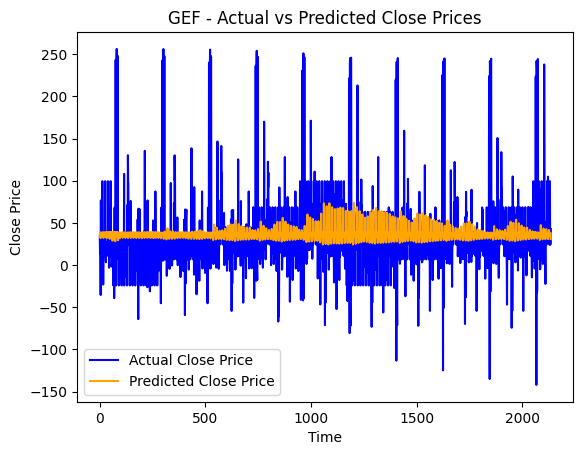

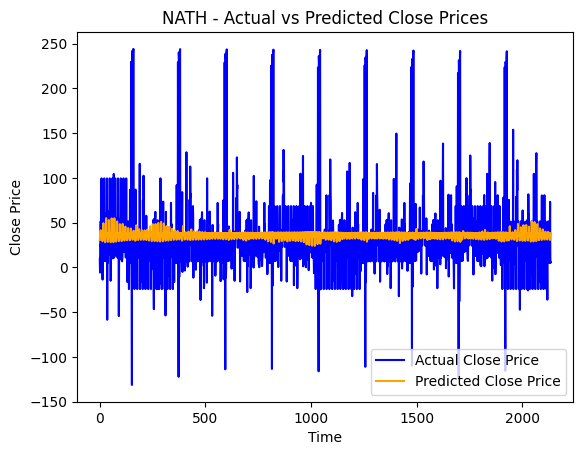

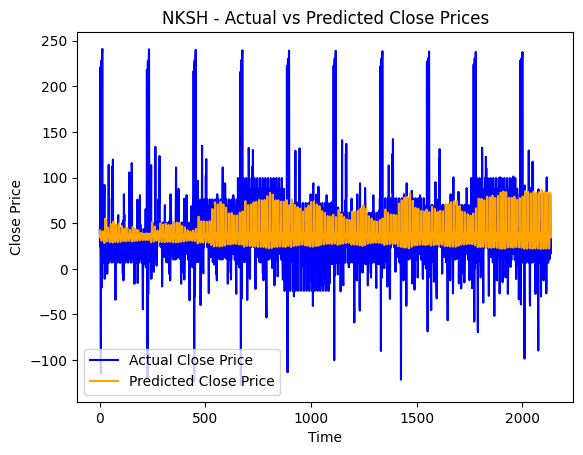

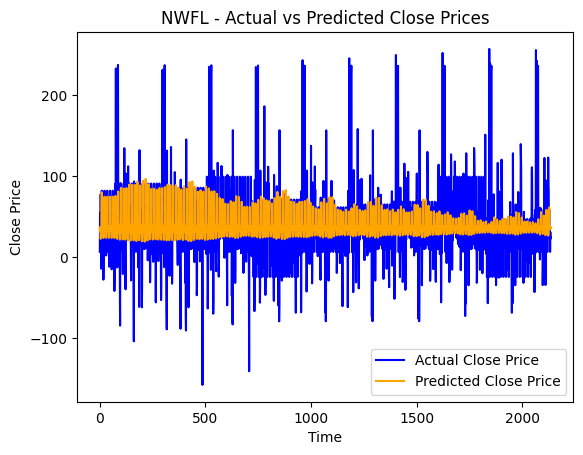

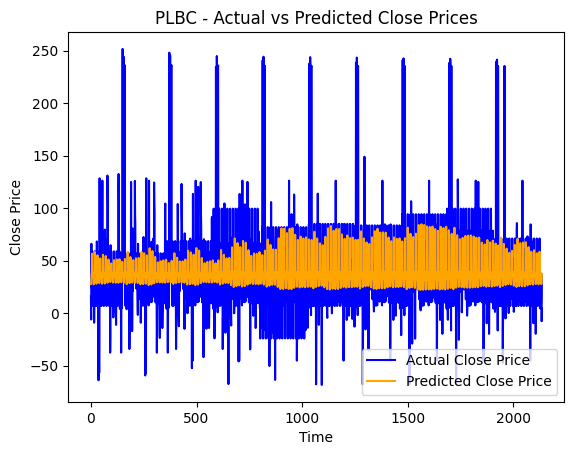

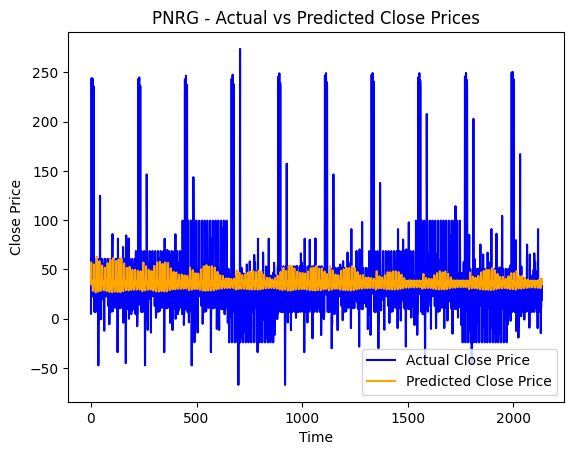

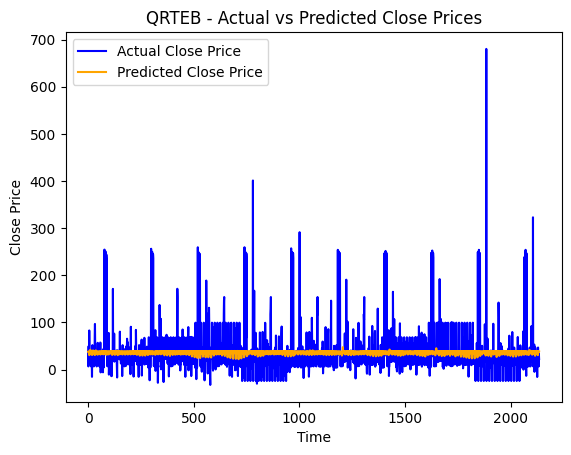

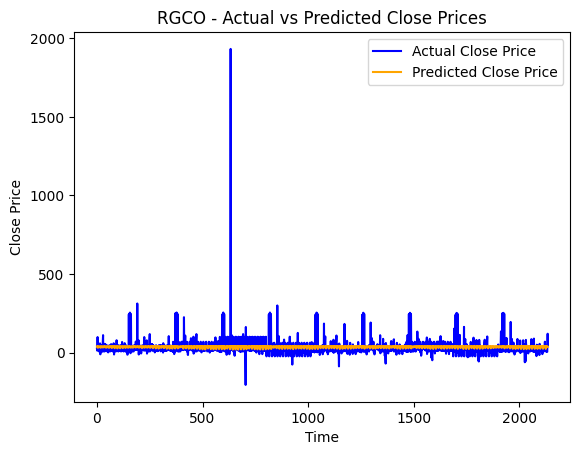

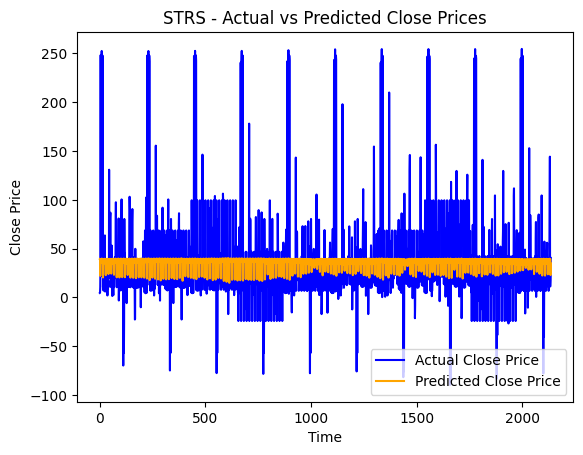

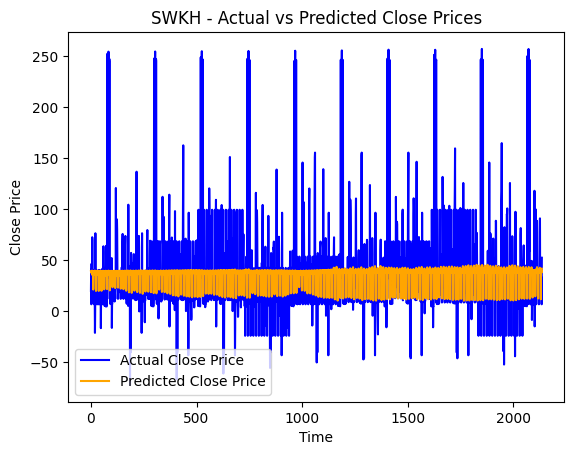

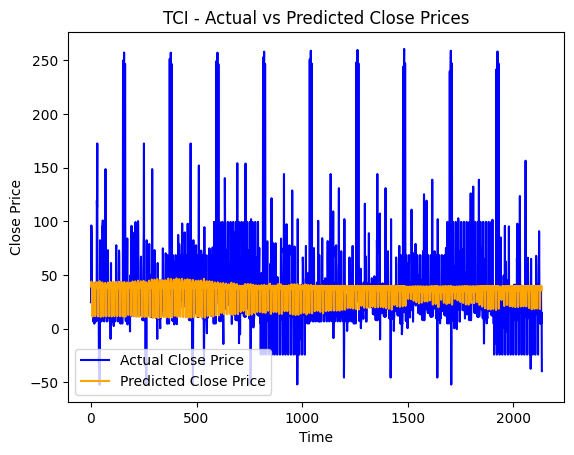

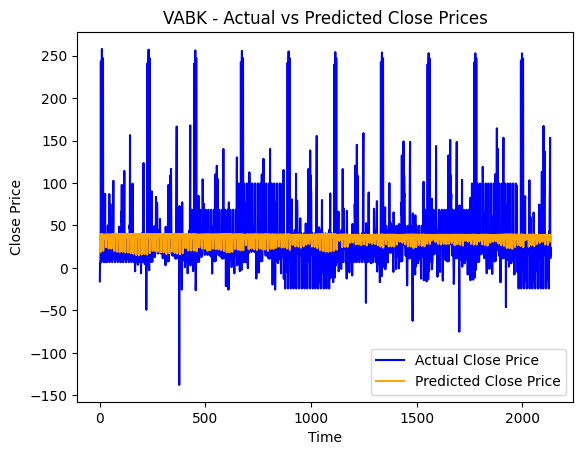

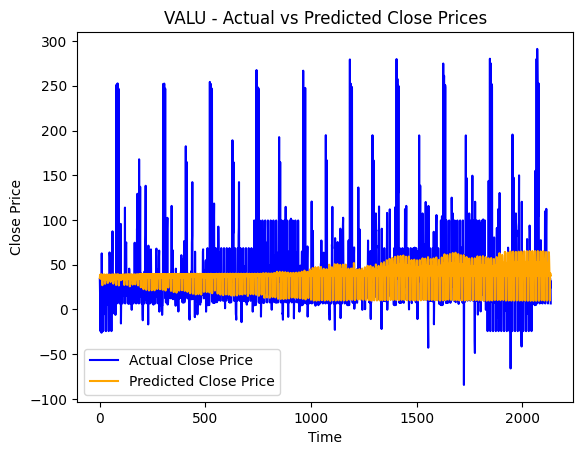

In [53]:
import matplotlib.pyplot as plt

# Get stock tickers from the dataset to identify stocks
stock_tickers = data['tic'].unique()

# Group predictions and actual values by stock ticker
predictions_per_stock = {}
actuals_per_stock = {}

for ticker in stock_tickers:
    # Filter out data for each ticker
    ticker_data = data[data['tic'] == ticker].iloc[sequence_length:]
    
    # Get predicted and actual closing prices for each stock ticker
    predictions_per_stock[ticker] = test_output[:len(ticker_data)]
    actuals_per_stock[ticker] = actual_prices[:len(ticker_data)]
    
    # Update test_output and actual_prices for next stock ticker if necessary
    test_output = test_output[len(ticker_data):]
    actual_prices = actual_prices[len(ticker_data):]

# Plot actual vs predicted closing prices for each stock
plt.figure(figsize=(14, 8))
for ticker in stock_tickers:
    plt.figure()
    plt.plot(actuals_per_stock[ticker], label='Actual Close Price', color='blue')
    plt.plot(predictions_per_stock[ticker], label='Predicted Close Price', color='orange')
    plt.title(f'{ticker} - Actual vs Predicted Close Prices')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
